In [1]:
import torch
from torch.autograd import Variable
import warnings
from torch import nn
from collections import OrderedDict
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

# Generator Check

In [3]:
# fix this stuff below. visualize generator output and filters for conv

In [35]:
def load_netG(path, isize, nz, nc, ngf, n_extra_layers):
    assert isize % 16 == 0, "isize has to be a multiple of 16"

    cngf, tisize = ngf//2, 4
    while tisize != isize:
        cngf = cngf * 2
        tisize = tisize * 2

    main = nn.Sequential()
    # input is Z, going into a convolution
    main.add_module('initial:{0}-{1}:convt'.format(nz, cngf),
                    nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
    main.add_module('initial:{0}:batchnorm'.format(cngf),
                    nn.BatchNorm2d(cngf))
    main.add_module('initial:{0}:relu'.format(cngf),
                    nn.ReLU(True))

    csize, cndf = 4, cngf
    while csize < isize//2:
        main.add_module('pyramid:{0}-{1}:convt'.format(cngf, cngf//2),
                        nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
        main.add_module('pyramid:{0}:batchnorm'.format(cngf//2),
                        nn.BatchNorm2d(cngf//2))
        main.add_module('pyramid:{0}:relu'.format(cngf//2),
                        nn.ReLU(True))
        cngf = cngf // 2
        csize = csize * 2

    # Extra layers
    for t in range(n_extra_layers):
        main.add_module('extra-layers-{0}:{1}:conv'.format(t, cngf),
                        nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
        main.add_module('extra-layers-{0}:{1}:batchnorm'.format(t, cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('extra-layers-{0}:{1}:relu'.format(t, cngf),
                        nn.ReLU(True))

    main.add_module('final:{0}-{1}:convt'.format(cngf, nc),
                    nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
    main.add_module('final:{0}:tanh'.format(nc),
                    nn.Tanh())
    
    state_dict = torch.load(path, map_location=torch.device('cpu'))

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `main.`
        new_state_dict[name] = v
    
    main.load_state_dict(new_state_dict, strict=False)
    
    return main

In [36]:
def load_netG_mlp(path, isize, nz, nc, ngf):
    
    main = nn.Sequential(
        # Z goes into a linear of size: ngf
        nn.Linear(nz, ngf),
        nn.ReLU(True),
        nn.Linear(ngf, ngf),
        nn.ReLU(True),
        nn.Linear(ngf, ngf),
        nn.ReLU(True),
        nn.Linear(ngf, nc * isize * isize),
    )
    
    state_dict = torch.load(path, map_location=torch.device('cpu'))

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `main.`
        new_state_dict[name] = v
    
    main.load_state_dict(new_state_dict, strict=False)
    
    return main

In [37]:
path = './loss_curves/netG_5k.pth'
netG_5k = load_netG(path, isize=32, nz=100, nc=1, ngf=64, n_extra_layers=0)

In [38]:
path = './loss_curves/netG_5k_mlp.pth'
netG_5k_mlp = load_netG_mlp(path, isize=25, nz=100, nc=1, ngf=640)

In [28]:
netG_5k = torch.load('./WassersteinGAN/loss_curves/netG_5k.pth', map_location=torch.device('cpu'))
netG_5k_mlp = torch.load('./WassersteinGAN/loss_curves/netG_5k_mlp.pth', map_location=torch.device('cpu'))

In [39]:
batchSize = 27
nz = 100
noise = torch.FloatTensor(batchSize, 1, 25, 25)

In [40]:
noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise, volatile = True) 
fake_5k = Variable(netG_5k(noisev).data)

## Individual Rows

In [137]:
# netG_5k samples
torch.round(fake_5k[3,0,3,3:].data).numpy()[:-4]

array([ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  0.,  0., -0., -0., -0.,  0., -0.,  0.],
      dtype=float32)

In [138]:
torch.round(fake_5k[4,0,3,3:].data).numpy()[:-4]

array([ 1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        1.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.],
      dtype=float32)

In [139]:
torch.round(fake_5k[5,0,3,3:].data).numpy()[:-4]

array([ 1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0., -0.,  0.,  0., -0.,
        1.,  0.,  0., -0.,  0.,  0., -0., -0., -0.,  0., -0.,  0.],
      dtype=float32)

In [140]:
torch.round(fake_5k[6,0,3,3:].data).numpy()[:-4]

array([ 0.,  1., -0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.],
      dtype=float32)

In [141]:
torch.round(fake_5k[7,0,6,3:].data).numpy()[:-4]

array([-0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0., -0., -0.,
        0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0., -0., -0., -0.],
      dtype=float32)

In [142]:
torch.round(fake_5k[12,0,4,3:].data).numpy()[:-4]

array([ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  0., -0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0., -0.],
      dtype=float32)

## Visualizing fake samples

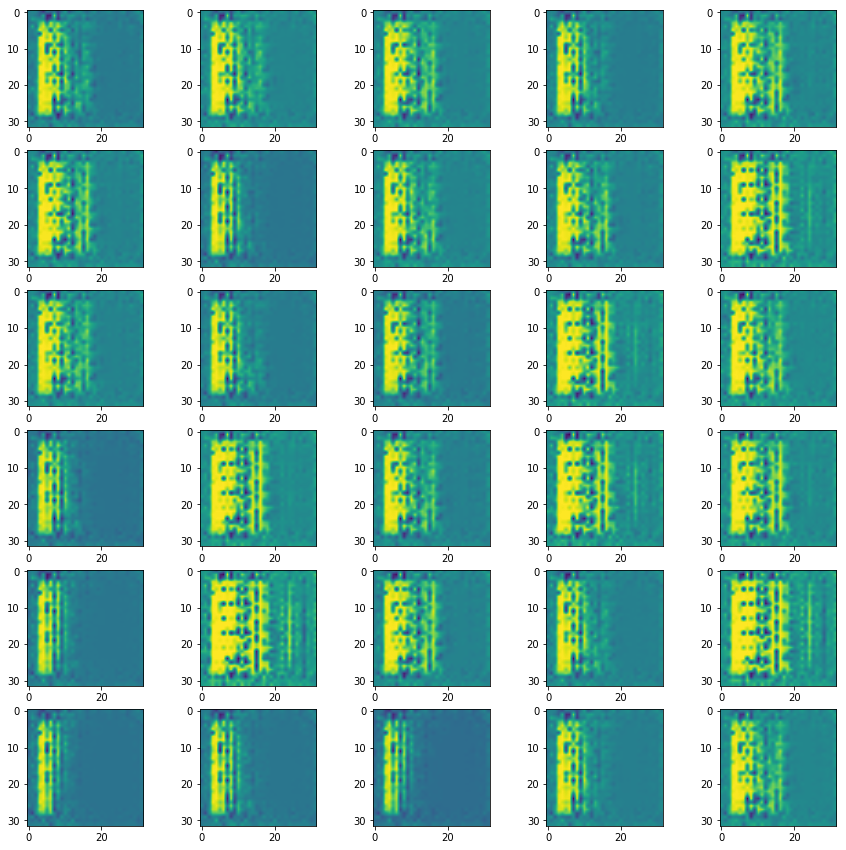

In [156]:
num_rows = 6
num_cols = 5
isize = 32
fig, axs = plt.subplots(num_rows, num_cols, figsize = (15, 15))
for i, axscol in enumerate(axs):
    for j, ax in enumerate(axscol):
        ax.imshow(fake_5k[j + num_cols * i].data.numpy().reshape((isize, isize)), interpolation = 'bilinear')

# Critic Evaluation of HMs

In [7]:

def load_netD(path, isize, nc, ndf, n_extra_layers):
    
    assert isize % 16 == 0, "isize has to be a multiple of 16"

    main = nn.Sequential()
    # input is nc x isize x isize
    main.add_module('initial:{0}-{1}:conv'.format(nc, ndf),
                    nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
    main.add_module('initial:{0}:relu'.format(ndf),
                    nn.LeakyReLU(0.2, inplace=True))
    csize, cndf = isize / 2, ndf

    # Extra layers
    for t in range(n_extra_layers):
        main.add_module('extra-layers-{0}:{1}:conv'.format(t, cndf),
                        nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
        main.add_module('extra-layers-{0}:{1}:batchnorm'.format(t, cndf),
                        nn.BatchNorm2d(cndf))
        main.add_module('extra-layers-{0}:{1}:relu'.format(t, cndf),
                        nn.LeakyReLU(0.2, inplace=True))

    while csize > 4:
        in_feat = cndf
        out_feat = cndf * 2
        main.add_module('pyramid:{0}-{1}:conv'.format(in_feat, out_feat),
                        nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
        main.add_module('pyramid:{0}:batchnorm'.format(out_feat),
                        nn.BatchNorm2d(out_feat))
        main.add_module('pyramid:{0}:relu'.format(out_feat),
                        nn.LeakyReLU(0.2, inplace=True))
        cndf = cndf * 2
        csize = csize / 2

    # state size. K x 4 x 4
    main.add_module('final:{0}-{1}:conv'.format(cndf, 1),
                    nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))

    state_dict = torch.load(path, map_location=torch.device('cpu'))

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `module.`
        new_state_dict[name] = v

    main.load_state_dict(new_state_dict, strict=False)
    return main
    

In [8]:
def load_netD_mlp(path, isize, nc, ndf):
    
    main = nn.Sequential(
            # Z goes into a linear of size: ndf
            nn.Linear(nc * isize * isize, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )
    
    state_dict = torch.load(path, map_location=torch.device('cpu'))
    
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `module.`
        new_state_dict[name] = v
    
    main.load_state_dict(new_state_dict, strict=False)
    return main

In [9]:
def reshape_mlp_input(input_sample):
    return input_sample.view(input_sample.size(0), 
                             input_sample.size(1) * input_sample.size(2) * input_sample.size(3))

In [18]:
path = './loss_curves/netD_50k_mlp_40df.pth'
netD_mlp = load_netD_mlp(path, isize=25, nc=1, ndf=40)

In [19]:
path = './loss_curves/netD_50k.pth'
netD = load_netD(path, isize=32, nc=1, ndf=64, n_extra_layers=0)

In [10]:
import data as data
from data.BehavioralDataset import BehavioralDataset
from data.BehavioralHmSamples import BehavioralHmSamples

In [13]:
dataset_dcgan = BehavioralDataset(isCnnData=True, isScoring=False)
dataset_mlp = BehavioralDataset(isCnnData=False, isScoring=False)
fake_samples_m1_dcgan = BehavioralHmSamples(modelNum=1, isCnnData=True, isScoring=False)
fake_samples_m1_mlp = BehavioralHmSamples(modelNum=1, isCnnData=False, isScoring=False)
fake_samples_m2_dcgan = BehavioralHmSamples(modelNum=2, isCnnData=True, isScoring=False)
fake_samples_m2_mlp = BehavioralHmSamples(modelNum=2, isCnnData=False, isScoring=False)
fake_samples_m3_dcgan = BehavioralHmSamples(modelNum=3, isCnnData=True, isScoring=False)
fake_samples_m4_dcgan = BehavioralHmSamples(modelNum=4, isCnnData=True, isScoring=False)
fake_samples_m5_dcgan = BehavioralHmSamples(modelNum=5, isCnnData=True, isScoring=False)

In [14]:
# read in real samples
dataloader_dcgan = torch.utils.data.DataLoader(dataset_dcgan, batch_size=30, shuffle=True, num_workers=2)
dataloader_mlp = torch.utils.data.DataLoader(dataset_mlp, batch_size=30, shuffle=True, num_workers=2)
data_iter_dcgan = iter(dataloader_dcgan)
data_iter_mlp = iter(dataloader_mlp)

In [15]:
data = data_iter_mlp.next()
data_samples, _ = data

In [12]:
# must balance out proportion of reals to fakes 
fake_datasets_dcgan = [dataset_dcgan, dataset_dcgan, fake_samples_m1_dcgan, fake_samples_m2_dcgan] 
fake_datasets_mlp = [dataset_mlp, dataset_mlp, fake_samples_m1_mlp, fake_samples_m2_mlp] 

In [243]:
all_scores_dcgan = []
input = torch.FloatTensor(30, 1, 32, 32)
for dataset in fake_datasets_dcgan:
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=30, shuffle=True, num_workers=2)
    data_iter = iter(dataloader)
    data = data_iter.next()
    fake_samples, _ = data
    input.resize_as_(fake_samples).copy_(fake_samples)
    inputv = Variable(input)
    
    critic_scores = netD(inputv)
    all_scores_dcgan.append(critic_scores.data.numpy().reshape(30,1))

In [234]:
# make random noise 
batchSize = 30
isize = 32
noise = torch.FloatTensor(batchSize, 1, isize, isize)
noise.resize_(batchSize, 1, isize, isize).normal_(0, 1)
noisev = Variable(noise, volatile = True) 

critic_scores = netD(noisev)
all_scores_dcgan.append(critic_scores.data.numpy().reshape(30,1))

In [235]:
# make striped random noise arrays
samples = []
for i in range(batchSize):
    next_row = np.array(np.random.normal(size=32))
    next_sample = [next_row for i in range(32)]
    next_sample = np.vstack(next_sample)
    samples.append(next_sample)

noise = np.dstack(samples).reshape(30, 1, 32, 32)
noisev = Variable(torch.from_numpy(noise))

critic_scores = netD(noisev.float())
all_scores_dcgan.append(critic_scores.data.numpy().reshape(30,1))

In [239]:
# perform platt scaling on scores
def classify(all_scores, num_fake_datasets):
    '''
    perform platt scaling on scores
    all_scores is a list of scores by datase
    '''
    
    all_scores = tuple(all_scores)
    scores = np.vstack(all_scores)
    true_labels = np.vstack((np.ones((30 * num_fake_datasets,1)), np.zeros((30 * num_fake_datasets,1))))
    
    clf = LogisticRegression().fit(scores, true_labels)
    pred_labels = clf.predict(scores)
    print(pred_labels)
    
    pass_as_real = []
    for i in range(num_fake_datasets*2):
        pass_as_real.append(np.sum(pred_labels[30 * i:30 * (i+1),]==np.ones((1,30))))
    
    return pass_as_real
    

In [244]:
pass_as_real = classify(all_scores_dcgan, 2)
print('----------------')
print('Pass As Real Samples')
print('Real Dataset: ', pass_as_real[0])
print('Real Dataset Again: ', pass_as_real[1])
print('Model 1: ', pass_as_real[2])
print('Model 2: ', pass_as_real[3])

[0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.]
----------------
Pass As Real Samples
Real Dataset:  15
Real Dataset Again:  15
Model 1:  12
Model 2:  16


In [245]:
np.hstack((all_scores_dcgan[0], all_scores_dcgan[2], all_scores_dcgan[3]))

array([[-2.2608209e-03, -4.2747897e-03, -1.4156777e-03],
       [-7.7832104e-03, -5.4339697e-03,  1.4359992e-03],
       [-7.2727888e-03, -8.1140385e-04, -6.8533276e-03],
       [-1.9232417e-03,  2.0751841e-03, -1.4749343e-03],
       [-8.0274502e-03, -1.2337635e-04,  1.6833484e-04],
       [-4.4412669e-03, -6.5815044e-03, -3.3846581e-03],
       [-1.6117808e-03, -4.0098168e-03, -6.5688048e-03],
       [-5.0150650e-04, -9.8818084e-03, -7.2888485e-03],
       [ 7.6348044e-04, -5.9395833e-03, -4.7061532e-03],
       [-4.3608537e-03, -1.3229520e-03, -2.8000460e-03],
       [-7.2372577e-04,  3.6333170e-04, -3.8032308e-03],
       [-9.1889352e-03,  2.3863092e-03, -3.3370147e-03],
       [-9.6115470e-03,  1.7055825e-03, -1.7273210e-03],
       [-2.6363479e-03, -7.2971457e-03, -6.7038145e-03],
       [-5.7192524e-03,  1.6225901e-03, -5.2699288e-03],
       [-6.5074773e-03,  8.3904021e-04,  1.2960688e-03],
       [-4.6839458e-03, -9.6110692e-03,  2.4584660e-03],
       [-3.6352666e-03, -7.1754

In [313]:
all_scores_mlp = []
input = torch.FloatTensor(30, 1, 25, 25)
for dataset in fake_datasets_mlp:
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=30, shuffle=True, num_workers=2)
    data_iter = iter(dataloader)
    data = data_iter.next()
    fake_samples, _ = data
    input.resize_as_(fake_samples).copy_(fake_samples)
    inputv = Variable(input)
    
    critic_scores = netD_mlp(reshape_mlp_input(inputv))
    all_scores_mlp.append(critic_scores.data.numpy().reshape(30,1))

In [314]:
pass_as_real = classify(all_scores_mlp, 2)
print('----------------')
print('Pass As Real Samples')
print('Real Dataset: ', pass_as_real[0])
print('Real Dataset Again: ', pass_as_real[1])
print('Model 1: ', pass_as_real[2])
print('Model 2: ', pass_as_real[3])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------
Pass As Real Samples
Real Dataset:  0
Real Dataset Again:  0
Model 1:  0
Model 2:  0


In [315]:
np.hstack((all_scores_mlp[0], all_scores_mlp[1], all_scores_mlp[2]))

array([[0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.00857298, 0.00857298, 0.00857298],
       [0.

## With Random Arrays and Random Striped Arrays

In [47]:
# must balance out proportion of reals to fakes 
fake_datasets_dcgan = [dataset_dcgan, dataset_dcgan, dataset_dcgan, dataset_dcgan, dataset_dcgan, dataset_dcgan, dataset_dcgan, dataset_dcgan, fake_samples_m1_dcgan, fake_samples_m2_dcgan, fake_samples_m3_dcgan, fake_samples_m4_dcgan, fake_samples_m5_dcgan] 
fake_datasets_mlp = [dataset_mlp, dataset_mlp, dataset_mlp, dataset_mlp, dataset_mlp, fake_samples_m1_mlp, fake_samples_m2_mlp] 

In [48]:
all_scores_dcgan = []
batchSize = 27
input = torch.FloatTensor(batchSize, 1, 32, 32)
for dataset in fake_datasets_dcgan:
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=2)
    data_iter = iter(dataloader)
    data = data_iter.next()
    fake_samples, _ = data
    input.resize_as_(fake_samples).copy_(fake_samples)
    inputv = Variable(input)
    
    critic_scores = netD(inputv)
    all_scores_dcgan.append(critic_scores.data.numpy().reshape(batchSize,1))

In [49]:
# make random noise 
isize = 32
noise = torch.FloatTensor(batchSize, 1, isize, isize)
noise.resize_(batchSize, 1, isize, isize).normal_(0, 1)
noisev = Variable(noise, volatile = True) 

critic_scores = netD(noisev)
all_scores_dcgan.append(critic_scores.data.numpy().reshape(batchSize,1))

In [50]:
# make striped random noise arrays
samples = []
for i in range(batchSize):
    next_row = np.array(np.random.normal(size=32))
    next_sample = [next_row for i in range(32)]
    next_sample = np.vstack(next_sample)
    samples.append(next_sample)

noise = np.dstack(samples).reshape(batchSize, 1, 32, 32)
noisev = Variable(torch.from_numpy(noise))

critic_scores = netD(noisev.float())
all_scores_dcgan.append(critic_scores.data.numpy().reshape(batchSize,1))

In [51]:
# add fake samples from DCGAN generator 
input.resize_as_(fake_5k).copy_(fake_5k)
inputv = Variable(input)

critic_scores = netD(inputv)
all_scores_dcgan.append(critic_scores.data.numpy().reshape(batchSize,1))

In [255]:
pass_as_real = classify(all_scores_dcgan, 4)
print('----------------')
print('Pass As Real Samples')
print('Real Dataset: ', pass_as_real[0])
print('Completely Random Array: ', pass_as_real[6])
print('Random Striped Array: ', pass_as_real[7])
print('Model 1: ', pass_as_real[4])
print('Model 2: ', pass_as_real[5])

[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------
Pass As Real Samples
Real Dataset:  28
Completely Random Array:  0
Random Striped Array:  0
Model 1:  27
Model 2:  27


In [58]:
len(all_scores_dcgan)

16

In [75]:
vals = all_scores_dcgan[1].reshape(1,batchSize).tolist()[0]
num_sample_sets = len(all_scores_dcgan)
for i in range(num_sample_sets//2, num_sample_sets):
    #print(i)
    vals = vals + all_scores_dcgan[i].reshape(1,batchSize).tolist()[0]

labels_names = ['Real', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Completely Random', 'Random Striped', 'Generator Samples']
labels = []
for name in labels_names:
    labels = labels + [name] * batchSize
scores_df = pd.DataFrame(list(zip(vals, labels)), columns=['Critic Score', 'Sample Type'])

In [73]:
vals = all_scores_dcgan[0].reshape(1,batchSize).tolist()[0] + all_scores_dcgan[8].reshape(1,batchSize).tolist()[0] + all_scores_dcgan[9].reshape(1,batchSize).tolist()[0] + all_scores_dcgan[10].reshape(1,batchSize).tolist()[0] + all_scores_dcgan[15].reshape(1,batchSize).tolist()[0] + all_scores_dcgan[15].reshape(1,batchSize).tolist()[0]
labels = ['Real'] * batchSize + ['Model 1'] * batchSize + ['Model 2'] * batchSize + ['Completely Random'] * batchSize + ['Random Striped'] * batchSize
scores_df = pd.DataFrame(list(zip(vals, labels)), columns=['Critic Score', 'Sample Type'])

Text(0.5,1,'DCGAN Critic')

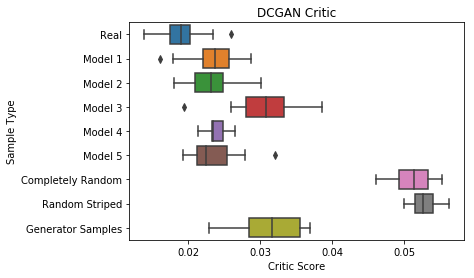

In [76]:
ax = sns.boxplot(x="Critic Score", y="Sample Type", data=scores_df)
ax.set_title('DCGAN Critic')

In [317]:
all_scores_mlp = []
input = torch.FloatTensor(30, 1, 25, 25)
for dataset in fake_datasets_mlp:
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=30, shuffle=True, num_workers=2)
    data_iter = iter(dataloader)
    data = data_iter.next()
    fake_samples, _ = data
    input.resize_as_(fake_samples).copy_(fake_samples)
    inputv = Variable(input)
    
    critic_scores = netD_mlp(reshape_mlp_input(inputv))
    all_scores_mlp.append(critic_scores.data.numpy().reshape(30,1))

In [318]:
# make random noise 
batchSize = 30
isize = 25
noise = torch.FloatTensor(batchSize, 1, isize, isize)
noise.resize_(batchSize, 1, isize, isize).normal_(0, 1)
noisev = Variable(noise, volatile = True) 

critic_scores = netD_mlp(reshape_mlp_input(noisev))
all_scores_mlp.append(critic_scores.data.numpy().reshape(30,1))

In [319]:
# make striped random noise arrays
samples = []
for i in range(batchSize):
    next_row = np.array(np.random.normal(size=isize))
    next_sample = [next_row for i in range(isize)]
    next_sample = np.vstack(next_sample)
    samples.append(next_sample)

noise = np.dstack(samples).reshape(30, 1, isize, isize)
noisev = Variable(torch.from_numpy(noise))

critic_scores = netD_mlp(reshape_mlp_input(noisev.float()))
all_scores_mlp.append(critic_scores.data.numpy().reshape(30,1))

In [320]:
pass_as_real = classify(all_scores_mlp, 4)
print('----------------')
print('Pass As Real Samples')
print('Real Dataset: ', pass_as_real[0])
print('Completely Random Array: ', pass_as_real[6])
print('Random Striped Array: ', pass_as_real[7])
print('Model 1: ', pass_as_real[4])
print('Model 2: ', pass_as_real[5])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------
Pass As Real Samples
Real Dataset:  0
Completely Random Array:  0
Random Striped Array:  0
Model 1:  0
Model 2:  0


In [321]:
vals = all_scores_mlp[0].reshape(1,30).tolist()[0] + all_scores_mlp[4].reshape(1,30).tolist()[0] + all_scores_mlp[5].reshape(1,30).tolist()[0] + all_scores_mlp[6].reshape(1,30).tolist()[0] + all_scores_mlp[7].reshape(1,30).tolist()[0]
labels = ['Real'] * 30 + ['Model 1'] * 30 + ['Model 2'] * 30 + ['Completely Random'] * 30 + ['Random Striped'] * 30
scores_df = pd.DataFrame(list(zip(vals, labels)), columns=['Critic Score', 'Sample Type'])

Text(0.5,1,'MLP Critic')

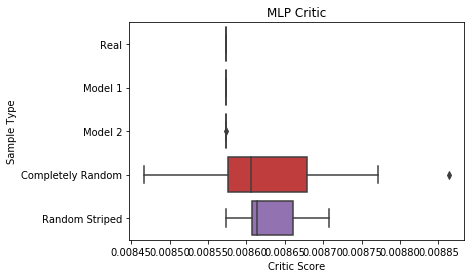

In [322]:
ax = sns.boxplot(x="Critic Score", y="Sample Type", data=scores_df)
ax.set_title('MLP Critic')

## Visualize Conv Filters

In [159]:
netD[0].weight.shape

torch.Size([64, 1, 4, 4])

In [164]:
netD

Sequential(
  (initial:1-64:conv): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (initial:64:relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (pyramid:64-128:conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (pyramid:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pyramid:128:relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (pyramid:128-256:conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (pyramid:256:batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pyramid:256:relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (final:256-1:conv): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

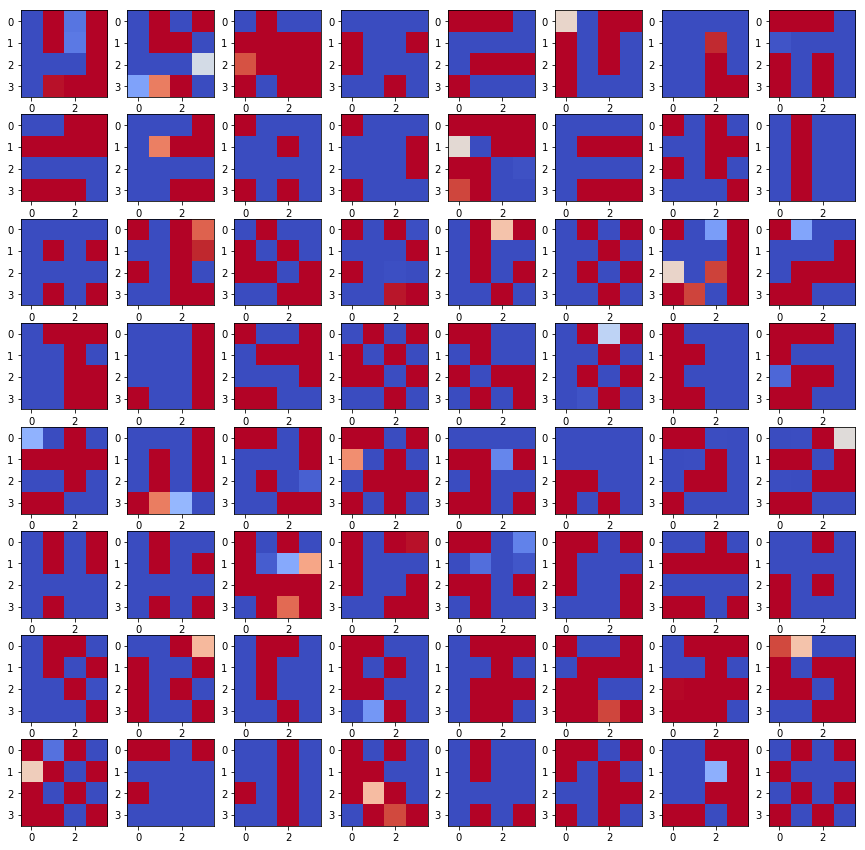

In [16]:
num_rows = 8
num_cols = 8
isize = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize = (15, 15))
for i, axscol in enumerate(axs):
    for j, ax in enumerate(axscol):
        ax.imshow(netD[0].weight[j + num_cols * i].detach().numpy().reshape((isize, isize)), cmap=plt.cm.coolwarm)